# Trying Variations 3.0

## 3. Changing the optimizer

1. Used SGD with different learning rate: 0.01
2. Adam with different learning rate: 0.001 and 0.0001, and weight decay: 1e-4
3. Adabound with different learning rate: 0.001 and weight decay: 1e-4

For Installing Adabound using pip use the following:
### !pip install adabound

In [1]:
!pip install adabound

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [4]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime
import os
import torchvision
import time
import copy
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [5]:
torch.__version__

'1.7.1+cu110'

In [6]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

##### Creating a function for getting training data CIFAR100

In [7]:
def give_me_train_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a train dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    # defining the transformations on the train data
    
    transformations = [transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std, inplace=True)]
    transform_train = transforms.Compose(transformations)
    
    train_set = CIFAR100('./data/cifar100', train=True, 
                         download=True, transform=transform_train)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs,
                                               shuffle=True, num_workers=num_workers)
    return train_loader

def give_me_test_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a test dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    # defining transformations on the test data
    
    transformations = [transforms.ToTensor(), transforms.Normalize(mean, std, inplace=True)]
    transform_test = transforms.Compose(transformations)
    
    valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, shuffle=False, 
                                             num_workers=num_workers)
    return val_loader

##### Creating the model architecture

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.layer1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3,
                                stride = 1, padding = 1)
        self.layer2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, 
                               stride = 1, padding = 1)
        self.layer3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, 
                               stride = 1, padding = 1)
        self.mxpool = nn.MaxPool2d(2, 2)
        self.mxpool1 = nn.MaxPool2d(2, 2, padding = 1)
        self.relu = nn.ReLU() # not used # instead used relu from Functional 'F' directly
        self.linear1 = nn.Linear(4096, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        self.linear3 = nn.Linear(1024, 100)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.mxpool(x)
        x = F.relu(self.layer2(x))
        x = self.mxpool1(x)
        x = F.relu(self.layer3(x))
        x = self.mxpool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) # using nn.CrossEntropy() that combines nn.LogSoftmax() and nn.NLLLoss() in one single class
        return x

In [9]:
# Initialize the weights of layers.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

##### Sending the model to gpu and printing the summary of the model architecture

In [10]:
device = 'cuda'
model = SimpleNet()
model.to(device) # sending our model to gpu.

# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         MaxPool2d-2           [-1, 64, 16, 16]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
         MaxPool2d-4            [-1, 128, 9, 9]               0
            Conv2d-5            [-1, 256, 9, 9]         295,168
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Linear-7                 [-1, 1024]       4,195,328
            Linear-8                 [-1, 1024]       1,049,600
            Linear-9                  [-1, 100]         102,500
Total params: 5,718,244
Trainable params: 5,718,244
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.16
Params size (MB): 21.81
Estimated Total Size (MB): 22.99
-------------------------------------

##### Preparing our data loaders for training and test.
Batch size is 128 (tried 256 and 512, 128 gives better performance)

In [11]:
train_loader = give_me_train_data(bs = 128, num_workers=4, shuffle=True)
val_loader = give_me_test_data(bs = 128, num_workers=4, shuffle=False)
model.apply(init_weights)
print("Weights initialized!")

Files already downloaded and verified
Files already downloaded and verified
Weights initialized!


In [12]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history, val_loss_history = [], []
    train_acc_history, train_loss_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_train = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        loss_train += loss.item()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
        # decreasing learning rate with the epochs
        scheduler.step(loss_train)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [13]:
# validate the training on validation set
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        print(name)
        print(loader)
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                y = model(imgs)
                _, predicted = torch.max(y, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.4f}".format(name, correct/total))
        print("{}: correct, total = {},{}".format(name, correct, total))

### Variation 3: Trying different Optimizers with different Learning Rates

#### 1. SGD, learning rate = 0.01

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [14]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.0490 Acc: 0.0851
val Loss: 3.6226 Acc: 0.1424

Epoch 2/10
----------
train Loss: 3.4163 Acc: 0.1798
val Loss: 3.1487 Acc: 0.2361

Epoch 3/10
----------
train Loss: 3.0746 Acc: 0.2411
val Loss: 2.8461 Acc: 0.2896

Epoch 4/10
----------
train Loss: 2.8282 Acc: 0.2880
val Loss: 2.6520 Acc: 0.3269

Epoch 5/10
----------
train Loss: 2.6313 Acc: 0.3286
val Loss: 2.4454 Acc: 0.3688

Epoch 6/10
----------
train Loss: 2.4644 Acc: 0.3622
val Loss: 2.3372 Acc: 0.3872

Epoch 7/10
----------
train Loss: 2.3219 Acc: 0.3928
val Loss: 2.2075 Acc: 0.4221

Epoch 8/10
----------
train Loss: 2.2067 Acc: 0.4155
val Loss: 2.1679 Acc: 0.4351

Epoch 9/10
----------
train Loss: 2.1003 Acc: 0.4409
val Loss: 2.0982 Acc: 0.4475

Epoch 10/10
----------
train Loss: 1.9858 Acc: 0.4639
val Loss: 2.0160 Acc: 0.4676

Training complete in 2m 11s
Best val Acc: 0.467600


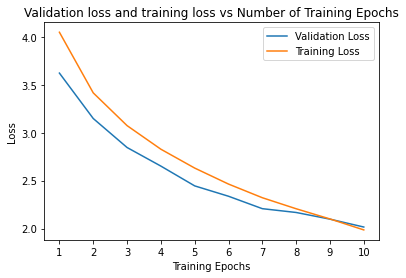

In [15]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [16]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.4971
train: correct, total = 24855,50000
val
Accuracy val: 0.4676
val: correct, total = 4676,10000


## *Please restart the kernel to reset the model parameters and run the cells 1-13 again before running the below code*

#### 2. Adam, learning rate = 0.001

In [14]:
max_lr = 0.001

weight_decay =1e-4
optimizer = optim.Adam(model.parameters(), max_lr, weight_decay = weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [15]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 3.8665 Acc: 0.0990
val Loss: 3.3539 Acc: 0.1893

Epoch 2/10
----------
train Loss: 3.2157 Acc: 0.2109
val Loss: 3.0068 Acc: 0.2522

Epoch 3/10
----------
train Loss: 2.8902 Acc: 0.2738
val Loss: 2.7378 Acc: 0.3101

Epoch 4/10
----------
train Loss: 2.6939 Acc: 0.3117
val Loss: 2.5214 Acc: 0.3535

Epoch 5/10
----------
train Loss: 2.5204 Acc: 0.3458
val Loss: 2.3802 Acc: 0.3803

Epoch 6/10
----------
train Loss: 2.3707 Acc: 0.3792
val Loss: 2.3339 Acc: 0.3895

Epoch 7/10
----------
train Loss: 2.2593 Acc: 0.4001
val Loss: 2.2832 Acc: 0.4107

Epoch 8/10
----------
train Loss: 2.1637 Acc: 0.4191
val Loss: 2.2007 Acc: 0.4266

Epoch 9/10
----------
train Loss: 2.0662 Acc: 0.4427
val Loss: 2.1661 Acc: 0.4335

Epoch 10/10
----------
train Loss: 1.9956 Acc: 0.4571
val Loss: 2.0942 Acc: 0.4440

Training complete in 2m 13s
Best val Acc: 0.444000


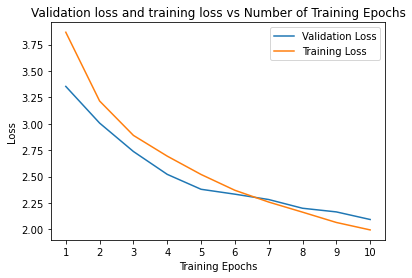

In [16]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [17]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.4815
train: correct, total = 24074,50000
val
Accuracy val: 0.4440
val: correct, total = 4440,10000


## *Please restart the kernel to reset the model parameters and run the cells 1-13 again before running the below code*

#### 3. Adam, learning rate = 0.0001, adding weight decay of 1e-4

In [14]:
max_lr = 0.0001
weight_decay =1e-4
optimizer = optim.Adam(model.parameters(), max_lr, weight_decay = weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [15]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.0090 Acc: 0.0920
val Loss: 3.6797 Acc: 0.1419

Epoch 2/10
----------
train Loss: 3.4661 Acc: 0.1755
val Loss: 3.2899 Acc: 0.2135

Epoch 3/10
----------
train Loss: 3.1901 Acc: 0.2231
val Loss: 3.0536 Acc: 0.2567

Epoch 4/10
----------
train Loss: 2.9952 Acc: 0.2608
val Loss: 2.8948 Acc: 0.2884

Epoch 5/10
----------
train Loss: 2.8723 Acc: 0.2863
val Loss: 2.8237 Acc: 0.3027

Epoch 6/10
----------
train Loss: 2.7641 Acc: 0.3060
val Loss: 2.6852 Acc: 0.3281

Epoch 7/10
----------
train Loss: 2.6568 Acc: 0.3279
val Loss: 2.5747 Acc: 0.3486

Epoch 8/10
----------
train Loss: 2.5705 Acc: 0.3459
val Loss: 2.4850 Acc: 0.3695

Epoch 9/10
----------
train Loss: 2.5005 Acc: 0.3603
val Loss: 2.4905 Acc: 0.3657

Epoch 10/10
----------
train Loss: 2.4326 Acc: 0.3772
val Loss: 2.3917 Acc: 0.3832

Training complete in 2m 12s
Best val Acc: 0.383200


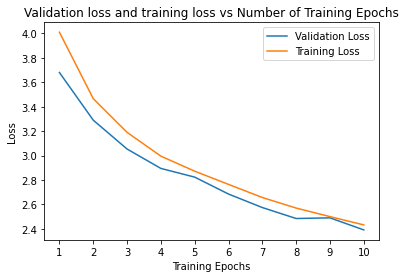

In [16]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [17]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.3904
train: correct, total = 19521,50000
val
Accuracy val: 0.3832
val: correct, total = 3832,10000


## *Please restart the kernel to reset the model parameters and run the cells 1-13 again before running the below code*

#### 4. Adabound, learning rate = 0.001, adding weight decay of 1e-4

In [14]:
import adabound
max_lr = 1e-3
grad_clip = 0.1
weight_decay =1e-4
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [15]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------


C:\Users\Anubhav\anaconda3\envs\mypytorch\lib\site-packages\adabound\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


train Loss: 3.8834 Acc: 0.0995
val Loss: 3.4449 Acc: 0.1627

Epoch 2/10
----------
train Loss: 3.2957 Acc: 0.1965
val Loss: 3.0855 Acc: 0.2443

Epoch 3/10
----------
train Loss: 3.0101 Acc: 0.2473
val Loss: 2.8682 Acc: 0.2795

Epoch 4/10
----------
train Loss: 2.8180 Acc: 0.2900
val Loss: 2.6848 Acc: 0.3209

Epoch 5/10
----------
train Loss: 2.6642 Acc: 0.3180
val Loss: 2.5544 Acc: 0.3491

Epoch 6/10
----------
train Loss: 2.5375 Acc: 0.3446
val Loss: 2.4332 Acc: 0.3761

Epoch 7/10
----------
train Loss: 2.4281 Acc: 0.3667
val Loss: 2.3405 Acc: 0.3922

Epoch 8/10
----------
train Loss: 2.3449 Acc: 0.3844
val Loss: 2.3543 Acc: 0.3920

Epoch 9/10
----------
train Loss: 2.2611 Acc: 0.4041
val Loss: 2.2584 Acc: 0.4120

Epoch 10/10
----------
train Loss: 2.1654 Acc: 0.4270
val Loss: 2.1998 Acc: 0.4268

Training complete in 2m 14s
Best val Acc: 0.426800


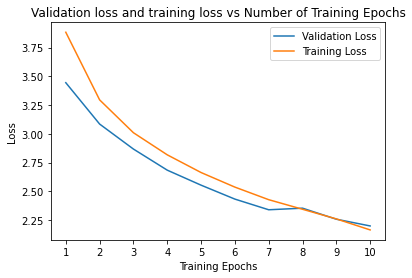

In [16]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [17]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.4551
train: correct, total = 22753,50000
val
Accuracy val: 0.4268
val: correct, total = 4268,10000
